In [7]:
import numpy as np
import pandas as pd
import os
from pymol import cmd
import glob

import seaborn as sns
import matplotlib.pyplot as plt

from src.SupertypeTools import CalcMat, CGCalcMat, dist_heatmap, SSE, hierarchical_cluster

### Kernel function curve

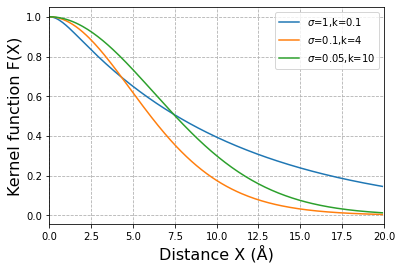

In [4]:
k_list = [0.1, 4, 10]
sigma_list = [1, 0.1, 0.05]
x = np.arange(0,20,0.1)


for w, sigma in zip(k_list, sigma_list):
    y3 = np.reciprocal(np.cosh(sigma*x))**w
    plt.plot(x,y3, label=f"$\sigma$={sigma},k={w}")
plt.xlabel("Distance X (Å)", fontsize=16)
plt.ylabel("Kernel function F(X)",fontsize=16)
plt.xlim([0,20])
plt.grid(linestyle='--')
plt.legend()
plt.savefig('kernel.png', dpi=300)
plt.show()


Change sigma


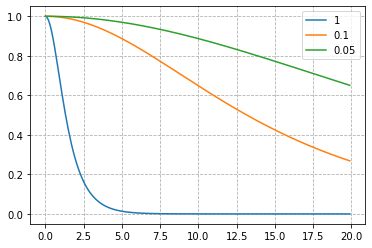

Change k


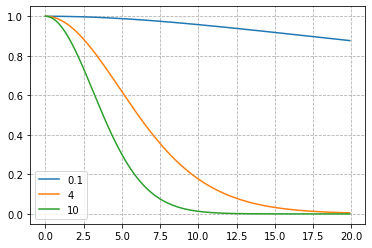

In [6]:
print("Change sigma")
for sigma in sigma_list:
    y2 = np.reciprocal(np.cosh(sigma*x))**1
    plt.plot(x,y2,label=sigma)

plt.legend()
plt.grid(linestyle='--')
plt.show()

print("Change k")
for k in k_list:
    y1 = np.reciprocal(np.cosh(0.1*x))**k
    plt.plot(x,y1,label=k)
plt.legend()
plt.grid(linestyle='--')
plt.show()

### Figure 1: Model quality

In [7]:
centroids = {"A01_01":"4NQX","A02_01":"3H7B","A02_03":"3OX8","A02_06":"3OXR",
        "A02_07":"3OXS","A03_01":"3RL2","A11_01":"6JOZ","A24_02":"4F7M",
        "A30_01":"6J1W","A30_03":"6J29","A68_01":"6PBH","B07_02":"5EO1",
        "B08_01":"4QRS","B14_02":"3BVN","B15_01":"3C9N","B18_01":"6MT3",
        "B27_03":"6PZ5","B27_04":"5DEF","B27_05":"3B6S","B27_06":"5DEG",
        "B27_09":"3HCV","B35_01":"1ZSD","B37_01":"6MT4","B39_01":"4O2E",
        "B40_01":"6IEX","B40_02":"5IEK","B42_01":"4U1M","B44_02":"3L3I",
        "B44_03":"1N2R","B46_01":"4LCY","B51_01":"4MJI","B57_01":"6D2B",
        "B58_01":"5IND","C03_04":"1EFX","C04_01":"1IM9","C05_01":"6JTO",
        "C06_02":"5W69","C08_01":"4NT6","C08_02":"6JTP"}

A_list = ["A01_01","A02_01","A02_03","A02_06","A02_07","A03_01","A11_01","A24_02","A30_01","A30_03","A68_01"]
B_list = ["B07_02","B08_01","B14_02","B15_01","B18_01","B27_03","B27_04","B27_05","B27_06","B27_09","B35_01",
        "B37_01","B39_01","B40_01","B40_02","B42_01","B44_02","B44_03","B46_01","B51_01","B57_01","B58_01"]
C_list = ["C03_04","C04_01","C05_01","C06_02","C08_01","C08_02"]

In [8]:
def Calculate_RMSD(InPDB, refPDB):
    cmd.load(refPDB, "template")
    cmd.load(InPDB, "target")

    FA_RMSD = cmd.align(f"target", f"template", cycles=0, transform=0)[0] # full-atom RMSD
    BB_RMSD = cmd.align(f"target////CA", f"template////CA", cycles=0, transform=0)[0] # back-bone RMSD

    cmd.delete("target")
    cmd.delete("template")

    return FA_RMSD, BB_RMSD

def Calculate_CG_RMSD(InDAT, RefDAT):
    """
    RMSD of coarse-grained representations assumes that residues are one-by-one aligned
    """
    in_df = pd.read_csv(InDAT)
    ref_df = pd.read_csv(RefDAT)
    non_missing_res = in_df['X'].notna() # filter out residues missing side chain
    in_coord = in_df.loc[non_missing_res,['X', 'Y', 'Z']].values
    ref_coord = ref_df.loc[non_missing_res,['X', 'Y', 'Z']].values

    RMSD = np.sqrt(np.linalg.norm(in_coord-ref_coord)**2/len(in_df))
    return RMSD

def RMSD_plot(Crystal_data, Model_data, weight1, weight2, label1, label2):
    plt.figure(figsize=(8,6))
    plt.hist(Crystal_data, weights=weight1, range=(0.0, 2.2), bins=21, histtype='step', linewidth=2, ec=(1, 0.6, 0, 1), label=label1, fill=True, fc=(1, 0.6, 0, 0.3))
    plt.hist(Model_data, weights=weight2, range=(0.0, 2.2), bins=21, histtype='step', linewidth=2, ec=(0, 0.6, 1, 1), label=label2, fill=True, fc=(0, 0.6, 1, 0.3))
    # (0, 0.6, 1, 1)
    plt.xlim((0.0, 2.2))
    plt.ylim((0, 0.4))
    plt.xlabel("RMSD (Å)", fontsize=16)
    plt.tick_params('x', labelsize=14)
    plt.tick_params('y', labelsize=14)
    plt.ylabel("probability", fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

    return

Full-atom


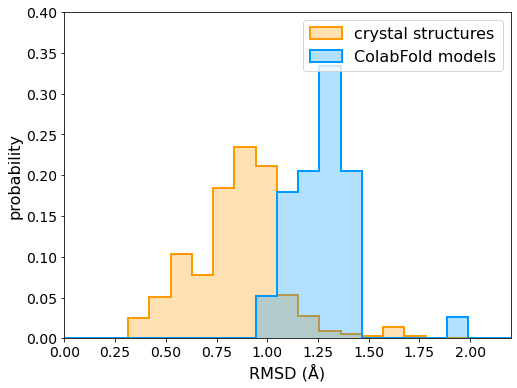

Back-Bone


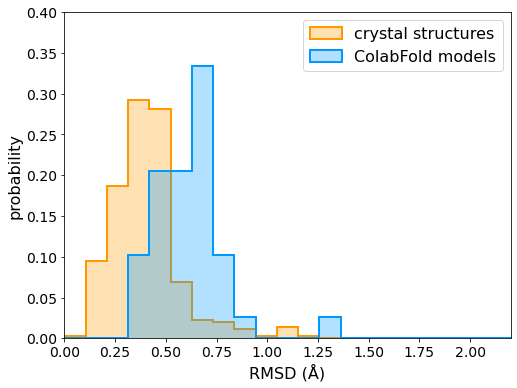

Coarse-grained


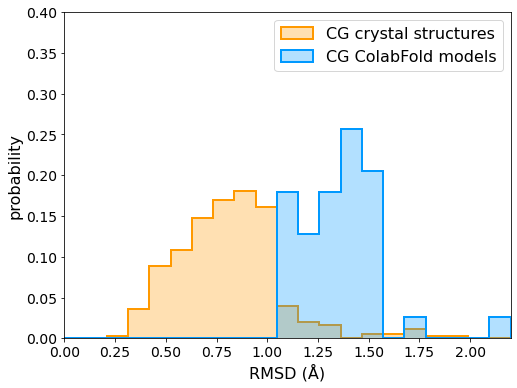

In [10]:
Model_dir = "HLA1_models"
Crystal_dir = "crystal/Class1"

Crystal_FA_rmsd = []
Crystal_BB_rmsd = []
Crystal_CG_rmsd = []

Model_FA_rmsd = []
Model_BB_rmsd = []
Model_CG_rmsd = []

for allele in A_list+B_list+C_list:
    Model_structure = f"{Model_dir}/ALIGN/{allele}.pdb"
    Crystal_structures = glob.glob(f"{Crystal_dir}/ALIGN/{allele}_*.pdb")
    Centroid_structure = f"{Crystal_dir}/ALIGN/{allele}_{centroids[allele]}.pdb"
    Crystal_structures.remove(Centroid_structure)
    
    Model_CG = f"{Model_dir}/CG_DAT/{allele}.csv"
    Crystal_CG = glob.glob(f"{Crystal_dir}/CG_DAT/{allele}_*.csv")
    Centroid_CG = f"{Crystal_dir}/CG_DAT/{allele}_{centroids[allele]}.csv"
    Crystal_CG.remove(Centroid_CG)

    for structure in Crystal_structures:
        FA_RMSD, BB_RMSD = Calculate_RMSD(structure, Centroid_structure)
        Crystal_FA_rmsd.append(FA_RMSD)
        Crystal_BB_rmsd.append(BB_RMSD)

    for structure_CG in Crystal_CG:
        CG_RMSD = Calculate_CG_RMSD(structure_CG, Centroid_CG)
        Crystal_CG_rmsd.append(CG_RMSD)


    mFA_RMSD, mBB_RMSD = Calculate_RMSD(Model_structure, Centroid_structure)
    Model_FA_rmsd.append(mFA_RMSD)
    Model_BB_rmsd.append(mBB_RMSD)

    mCG_RMSD = Calculate_CG_RMSD(Model_CG, Centroid_CG)
    Model_CG_rmsd.append(mCG_RMSD)

weights1 = np.ones_like(Crystal_FA_rmsd)/float(len(Crystal_FA_rmsd))
weights2 = np.ones_like(Model_FA_rmsd)/float(len(Model_FA_rmsd))

# =========== All atom RMSD ============
print("Full-atom")
RMSD_plot(Crystal_FA_rmsd, Model_FA_rmsd, weights1, weights2, label1="crystal structures", label2="ColabFold models")

# =========== Back bone RMSD =============
print("Back-Bone")
RMSD_plot(Crystal_BB_rmsd, Model_BB_rmsd, weights1, weights2, label1="crystal structures", label2="ColabFold models")

# =========== Coarse grained RMSD ===========
print("Coarse-grained")
RMSD_plot(Crystal_CG_rmsd, Model_CG_rmsd, weights1, weights2, label1="CG crystal structures", label2="CG ColabFold models")

In [15]:
np.mean(Crystal_CG_rmsd)

0.8150531096286057